In [1]:
its_jupyter_notebook = True

In [24]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from tqdm.notebook import tqdm
sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import balance_df, obtain_plot, plot_logs, plot_roc_curves, get_results_based_on_treshold, get_results_based_on_treshold, map_signal_to_sigmoid_range
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

In [25]:
checkpoint_dir_paths = []

chkpt_folder = os.path.join(ROOT_DIR, 'checkpoints')

models_to_check = os.listdir(chkpt_folder)
for model_name in models_to_check:
    model_folder = os.path.join(chkpt_folder, model_name)
    test_paris = os.path.join(chkpt_folder, model_name, 'test_results500.csv')
    ricseq = os.path.join(chkpt_folder, model_name, 'ricseq_results500.csv')
    splash = os.path.join(chkpt_folder, model_name, 'splash_results500.csv')
    if os.path.exists(test_paris) & os.path.exists(ricseq) & os.path.exists(splash) :
        checkpoint_dir_paths.append(model_folder)

In [26]:
def load_paris_results(checkpoint_dir, HOW, SPECIE, show_plot_map_signal=False):

    file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training.txt")
    with open(file_train, "rb") as fp:   # Unpickling
        gene_pairs_train_original = pickle.load(fp)

    file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt_HQ.txt")
    with open(file_train, "rb") as fp:   # Unpickling
        gene_pairs_train = pickle.load(fp)

    file_test = os.path.join(rna_rna_files_dir, f"gene_pairs_{HOW}_nt_HQ.txt")
    with open(file_test, "rb") as fp:   # Unpickling
        gene_pairs_test = pickle.load(fp)

    # file_test_subset = os.path.join(rna_rna_files_dir, f"gene_pairs_{HOW}_sampled_nt_HQ.txt")
    # with open(file_test_subset, "rb") as fp:   # Unpickling
    #     gene_pairs_test_subset = pickle.load(fp)
    
    #-------------- -------------- -------------- -------------- -------------- -------------- --------------
    
    test500 = pd.read_csv(os.path.join(metadata_dir, f'{HOW}500.csv'))
    assert test500.couples.isin(gene_pairs_test).all()

    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))

    assert test500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(test500, on = 'couples').shape[0]
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex']].merge(test500, on = 'couples')

    id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)
    
    #-------------- -------------- -------------- -------------- -------------- -------------- --------------
    
    res = pd.read_csv(os.path.join(checkpoint_dir, f'{HOW}_results500.csv'))

    # Drop all the pairs (they should be 60-70) that are present in the training set.
    res = res[~res.couples.isin(gene_pairs_train_original)]

    # show only results for 1 specie
    res = res[res.specie == SPECIE]

    #-------------- -------------- -------------- -------------- -------------- -------------- --------------
    
    intarna = pd.read_csv(os.path.join(intarna_dir, f'{HOW}500', f'{HOW}.csv'), sep = ';')
    intarna['key'] = intarna.id1 + '_' + intarna.id2

    # keep only the lower E_norm for each group
    intarna.sort_values('E_norm', ascending = False, inplace=True)
    intarna.drop_duplicates(subset='key', keep='first', inplace=True)
    intarna = intarna.reset_index(drop = True)
    intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
    intarna['couples'] = intarna['couples'].astype(int)

    # #merge with id of df_nt
    # df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
    # df_nt = df_nt[['couples', 'interacting']]
    # df_nt['interacting'] = df_nt['interacting'].astype(int)

    intarna = intarna.dropna()

    res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')
    res['original_area'] = res.original_length1 * res.original_length2
    
    #-------------- -------------- -------------- -------------- -------------- -------------- --------------
    
    intarna_treshold = -1.25

    # Example usage
    signal_range = np.linspace(-5, 0, 1000)

    mapped_signal = map_signal_to_sigmoid_range(signal_range, intarna_treshold)

    if show_plot_map_signal:
        # Plotting the results
        plt.plot(signal_range, mapped_signal, label='Mapped Signal')
        plt.axvline(x=intarna_treshold, color='r', linestyle='--', label='Intarna Threshold to be 0.5')
        plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')
        plt.xlabel('Original Signal')
        plt.ylabel('Mapped Signal')
        plt.legend()
        plt.show()

    # Ranking the 'E_norm' column in ascending order
    res['E_norm_conf'] = map_signal_to_sigmoid_range(res['E_norm'], intarna_treshold)
    res['E_norm_conf'] = 1 - res['E_norm_conf']

    ### L agreement score in questo caso di intarna non tiene conto dello sbilanciamento dei dati... dovrei prima trovare qual e l la soglia di INTARNA dove mettere lo 0.5 e poi fare la media con lo score del nostro modello
    res['ensemble_score'] = (res['probability'] + res['E_norm_conf']) / 2
    assert res.ensemble_score.max() <= 1
    assert res.ensemble_score.min() >= 0
    
    return res

def load_ricseq_splash_mario_results(checkpoint_dir, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, show_plot_map_signal=False):
    
    res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))
    
    if (how == 'ricseq')&filter_hq_ricseq:
        ricsechq = pd.read_csv(os.path.join(os.path.join('ricseqHQ_couples.csv')))
        hq = res[res.couples.isin(ricsechq['couples'])]
        pos_to_keep = list(hq[hq.policy == 'easypos'].id_sample)
        smartneg_to_drop = list(hq[hq.policy == 'smartneg'].id_sample)
        res = res[
            (res.id_sample.isin(pos_to_keep)) | 
            ((res.policy == 'smartneg') & (~res.id_sample.isin(smartneg_to_drop)) ) | 
            ((res.policy == 'hardneg') & (res.id_sample.isin(pos_to_keep)) ) |
            ((res.policy == 'easyneg') & (~res.id_sample.isin(smartneg_to_drop)) )
        ]
        
    #-------------- -------------- -------------- -------------- -------------- -------------- --------------
        
    file_train = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_training.txt')
    with open(file_train, "rb") as fp:   # Unpickling
        train_couples = pickle.load(fp)

    file_test = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_test.txt')
    with open(file_test, "rb") as fp:   # Unpickling
        test_couples = pickle.load(fp)

    train_paris = os.path.join(rna_rna_files_dir, 'gene_pairs_training.txt')
    with open(train_paris, "rb") as fp:   # Unpickling
        paris_couples1 = pickle.load(fp)
    val_paris = os.path.join(rna_rna_files_dir, 'gene_pairs_val.txt')
    with open(val_paris, "rb") as fp:   # Unpickling
        paris_couples2 = pickle.load(fp)

    paris_couples=pd.Series(list(set(paris_couples1).union(paris_couples2))).str.extractall('(.*)_(.*)').reset_index()
    paris_genes = set(paris_couples[0]).union(paris_couples[1])    
    paris_couples = set(paris_couples1).union(paris_couples2)


    tr_genes=pd.Series(train_couples).str.extractall('(.*)_(.*)').reset_index()
    training_genes = set(tr_genes[0]).union(tr_genes[1])

    if only_test:
        res = res[res.couples.isin(test_couples)]
        if exclude_train_genes:
            res = res[~(res.gene1_original.isin(training_genes) | res.gene2_original.isin(training_genes))]

    if exclude_paris_genes:
        n_original_couples=res.shape[0]
        res = res[~(res.gene1_original.isin(paris_genes) | res.gene2_original.isin(paris_genes))]
        print('# excluded couples: ', n_original_couples - res.shape[0])
    if exclude_paris_couples:
        n_original_couples=res.shape[0]
        res = res[~(res.couples.isin(paris_couples))]
        print('# excluded couples: ', n_original_couples - res.shape[0])
        
    #-------------- -------------- -------------- -------------- -------------- -------------- --------------
        
    test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))

    assert test500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(test500, on = 'couples').shape[0]

    if how == 'ricseq':
        test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
        ids_to_keep = set(test500[test500.n_reads >= MIN_N_READS_RICSEQ].couples).union(test500[test500.interacting==False].couples)
        res = res[res.id_sample.isin(ids_to_keep)]
    elif how == 'mario':
        test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
    elif how == 'splash':
        test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'experiment']].merge(test500, on = 'couples')
    else:
        raise NotImplementedError

    id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)
    
    #-------------- -------------- -------------- -------------- -------------- -------------- --------------
    
    intarna = pd.read_csv(os.path.join(intarna_dir, f'{how}500_RANDOM', f'{how}.csv'), sep = ';')
    intarna['key'] = intarna.id1 + '_' + intarna.id2

    # keep only the lower E_norm for each group
    intarna.sort_values('E_norm', ascending = False, inplace=True)
    intarna.drop_duplicates(subset='key', keep='first', inplace=True)
    intarna = intarna.reset_index(drop = True)
    intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
    intarna['couples'] = intarna['couples'].astype(int)

    intarna = intarna.dropna()


    res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')
    res['original_area'] = res.original_length1 * res.original_length2
    
    
    #-------------- -------------- -------------- -------------- -------------- -------------- --------------
    
    intarna_treshold = -1.25

    # Example usage
    signal_range = np.linspace(-5, 0, 1000)

    mapped_signal = map_signal_to_sigmoid_range(signal_range, intarna_treshold)
    
    if show_plot_map_signal:
        # Plotting the results
        plt.plot(signal_range, mapped_signal, label='Mapped Signal')
        plt.axvline(x=intarna_treshold, color='r', linestyle='--', label='Intarna Threshold to be 0.5')
        plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')
        plt.xlabel('Original Signal')
        plt.ylabel('Mapped Signal')
        plt.legend()
        plt.show()

    # Ranking the 'E_norm' column in ascending order
    res['E_norm_conf'] = map_signal_to_sigmoid_range(res['E_norm'], intarna_treshold)
    res['E_norm_conf'] = 1 - res['E_norm_conf']

    ### L agreement score in questo caso di intarna non tiene conto dello sbilanciamento dei dati... dovrei prima trovare qual e l la soglia di INTARNA dove mettere lo 0.5 e poi fare la media con lo score del nostro modello
    res['ensemble_score'] = (res['probability'] + res['E_norm_conf']) / 2
    assert res.ensemble_score.max() <= 1
    assert res.ensemble_score.min() >= 0
    
    return res

In [27]:
def obtain_auc_nt_intarna(res):
    fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
    roc_auc_nt = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(res.ground_truth, abs(res.E_norm))
    roc_auc_intarna = auc(fpr, tpr)
    return roc_auc_nt, roc_auc_intarna

In [28]:
def load_results(checkpoint_dir_paths, space, n_values, MIN_PERC, chkpt_folder):
    
    filename_output = os.path.join(chkpt_folder, 'model_performance.pkl')
    
    if os.path.exists(filename_output):
        # Loading the variables from the file
        with open(filename_output, 'rb') as file:
            df_full, name_map, confidence_level = pickle.load(file)
        
        to_do = list( set(checkpoint_dir_paths) - set(name_map.values()) )
        
        if len(to_do) > 0:
        
            new_df_full, new_name_map, new_confidence_level = otain_results(to_do, space, n_values, MIN_PERC, index_name = len(name_map))

            df_full = pd.concat([df_full,new_df_full], axis = 0).reset_index(drop = True)
            name_map.update(new_name_map)

            # Saving the variables to a file
            with open(filename_output, 'wb') as file:
                pickle.dump((df_full, name_map, confidence_level), file)

    else:
        df_full, name_map, confidence_level = otain_results(checkpoint_dir_paths, space, n_values, MIN_PERC)
        # Saving the variables to a file
        with open(filename_output, 'wb') as file:
            pickle.dump((df_full, name_map, confidence_level), file)
        
    return df_full, name_map, confidence_level

In [29]:
def add_row_values(task_name, set_name, subset, row, n_values, n_run_undersampling, MIN_PERC):
    for metric in ['precision_recall_curve', 'f1']:
        # Get results based on threshold for NT
        confidence_level, metric_nt, perc_nt, _, _, _, _ = get_results_based_on_treshold(subset=subset, MIN_PERC=MIN_PERC, n_values=n_values, order_by='nt', n_run_undersampling=n_run_undersampling, metric=metric, consensus=False)
        
        # Add NT confidence level results to row
        for i in range(len(confidence_level)):
            row[f'{set_name}_{task_name}_{metric}_NTconf{confidence_level[i]}'] = metric_nt[i]

        # Get results based on threshold for INTARNA
        _, _, _, metric_intarna, perc_intarna, _, _ = get_results_based_on_treshold(subset=subset, MIN_PERC=MIN_PERC, n_values=n_values, order_by='intarna', n_run_undersampling=n_run_undersampling, metric=metric, consensus=False)
        
        # Add INTARNA confidence level results to row
        for i in range(len(confidence_level)):
            row[f'{set_name}_{task_name}_{metric}_INTARNAconf{confidence_level[i]}'] = metric_intarna[i]
            
    fpr, tpr, _ = roc_curve(subset.ground_truth, subset.probability)
    roc_auc = auc(fpr, tpr)
    row[f'{set_name}_auc_NT_{task_name}'] = roc_auc

    fpr, tpr, _ = roc_curve(abs(1 - subset.ground_truth), subset.E_norm)
    roc_auc = auc(fpr, tpr)
    row[f'{set_name}_auc_INTARNA_{task_name}'] = roc_auc
    
    return row, confidence_level


def otain_results(checkpoint_dir_paths, space, n_values, MIN_PERC, index_name = 0):

    diz_results = {}
    name_map = {}
    
    for idx_v, checkpoint_dir in tqdm(enumerate(checkpoint_dir_paths), total = len(checkpoint_dir_paths)):
        row = {}

        # -----------
        # PARIS args
        # -----------
        
        HOW = 'test'
        SPECIE = 'human'
        
        # -----------------------
        # RICSEQ and SPLASH args
        # -----------------------

        only_test = False
        exclude_train_genes = False
        exclude_paris_genes = False
        exclude_paris_couples = True

        filter_hq_ricseq = False

        MIN_N_READS_RICSEQ = 3
        
        # -----------
        # Calculation
        # ------------
        
        n_run_undersampling = 30
        n_values = 12
        MIN_PERC = 1

        for how in ['paris', 'ricseq', 'splash']:
            
            if how == 'paris':
                res = load_paris_results(checkpoint_dir, HOW, SPECIE)

            else:
                res = load_ricseq_splash_mario_results(checkpoint_dir, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ)

            easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
            subset = easypos_smartneg.copy()
            subset = balance_df(subset).reset_index(drop = True)
            row, confidence_level = add_row_values('interactors', how, subset, row, n_values, n_run_undersampling, MIN_PERC)
            
            ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
            subset = ephnen.copy()
            subset = balance_df(subset).reset_index(drop = True)
            row, _ = add_row_values('patches', how, subset, row, n_values, n_run_undersampling, MIN_PERC)
            
        # -------------------
        # SPLASH RICSEQ test
        # -------------------
        only_test = True
        for how in ['ricseq', 'splash']:
            res = load_ricseq_splash_mario_results(checkpoint_dir, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ)
            easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
            subset = easypos_smartneg.copy()
            subset = balance_df(subset).reset_index(drop = True)
            row, _ = add_row_values('interactors', how+'test', subset, row, n_values, n_run_undersampling, MIN_PERC)
            
            ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
            subset = ephnen.copy()
            subset = balance_df(subset).reset_index(drop = True)
            row, _ = add_row_values('patches', how+'test', subset, row, n_values, n_run_undersampling, MIN_PERC)
            
        model_name = f'model{idx_v + index_name}'
        name_map[model_name] = checkpoint_dir
        diz_results[model_name] = row
    
    df = pd.DataFrame.from_dict(diz_results, 'index')
    df = df*100
    df = df.round(2)
    df = df.reset_index().rename({'index':'model'}, axis = 1)
    
    intarna_columns = []
    all_columns = list(df.columns)
    for col in all_columns:
        if 'INTARNA' in col:
            intarna_columns.append(col)


    df_intarna, other = df.filter(intarna_columns, axis = 1), df.filter(set(df.columns) - set(intarna_columns), axis = 1)

    map_name = {}
    for col in df_intarna.columns:
        if 'INTARNAconf' in col:
            col_clean = col.replace('INTARNAconf', 'NTconf')
            map_name[col] = col_clean
        elif 'INTARNA_' in col:
            col_clean = col.replace('INTARNA_', 'NT_')
            map_name[col] = col_clean
    df_intarna = df_intarna.rename(map_name, axis = 1)


    assert set(df_intarna.columns) - set(other.columns) == set()


    for col in (set(other.columns) - set(df_intarna.columns)):
        df_intarna[col] = np.nan


    df_intarna = pd.DataFrame(df_intarna.mean()).T
    df_intarna['model'] = 'INTARNA'
    df_intarna = df_intarna.filter(other.columns, axis = 1)
    df_full = pd.concat([other, df_intarna], axis = 0).reset_index(drop = True)
    
    
    map_name = {}
    for col in df_full.columns:
        if 'NTconf' in col:
            col_clean = col.replace('NTconf', 'conf')
            map_name[col] = col_clean
        elif 'NT_' in col:
            col_clean = col.replace('NT_', '')
            map_name[col] = col_clean
    df_full = df_full.rename(map_name, axis = 1).reset_index(drop = True)

    return df_full, name_map, confidence_level

In [30]:
space = 'linear'
n_values = 12
MIN_PERC = 1

assert space in ['log', 'linear']

In [42]:
df_full, name_map, confidence_level = load_results(checkpoint_dir_paths[:8], space, n_values, MIN_PERC, chkpt_folder)

#df = otain_results(checkpoint_dir_paths[:3], space, n_values, MIN_PERC)

  0%|          | 0/2 [00:00<?, ?it/s]

# excluded couples:  234
# excluded couples:  58
# excluded couples:  64
# excluded couples:  12
# excluded couples:  234
# excluded couples:  58
# excluded couples:  64
# excluded couples:  12


In [43]:
df_full = df_full.groupby('model').mean().reset_index()

# Curve

In [44]:
n_best = 5
min_auc_on_all_dataset = 0.53
way = 3

In [45]:
plt.rcParams['figure.figsize'] = [10, 7]

In [46]:
df_auc = df_full.filter(['model', 'paris_auc_interactors',  'ricseq_auc_interactors', 'splash_auc_interactors', 'splashtest_auc_interactors'])

In [47]:
if way == 1:
    #way1
    df_select = df_auc[(df_auc.drop('model', axis = 1) > min_auc_on_all_dataset * 100).all(axis = 1)]
    best_models = set(df_select.sort_values('mean', ascending = False).head(n_best)['model']).union(set(['INTARNA']))
elif way == 2:
    #way2
    best_paris = set(df_select.sort_values('paris_auc_interactors', ascending = False).head( int(n_best) )['model'])
    best_ricseq = set(df_select.sort_values('ricseq_auc_interactors', ascending = False).head( int(n_best) )['model'])
    best_splash = set(df_select.sort_values('splash_auc_interactors', ascending = False).head( int(n_best) )['model'])
    best_models = ( best_paris.intersection(best_ricseq).intersection(best_splash) ).union(set(['INTARNA']))
elif way == 3:
    #take the best in ricseq
    best_models = set(df_auc.sort_values('ricseq_auc_interactors', ascending = False).head(n_best)['model']).union(set(['INTARNA']))

In [60]:
task_name = 'interactors' #interactors, patches
metric = 'f1' #precision_recall_curve, f1
model_list = ['splashtest', 'ricseq', 'paris']

diz_curve = {}

for set_name in model_list:
    diz_dataset = {}
    for model in best_models:
        datasetlist = []
        for conf in confidence_level:
            modelrow = df_full[df_full['model'] == model]
            
            value = modelrow[f'{set_name}_{task_name}_{metric}_conf{conf}'].iloc[0]
            
            datasetlist.append(value)  
        diz_dataset[model] = datasetlist
    diz_curve[set_name] = diz_dataset

In [61]:
df_curve = pd.DataFrame.from_dict(diz_curve, 'index')#.reset_index().rename({'index':'dataset'}, axis = 1)

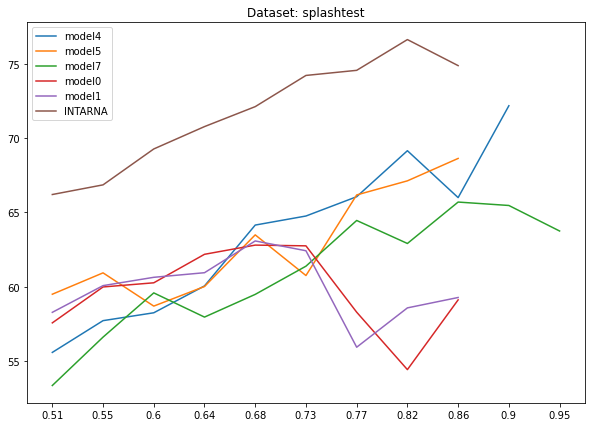

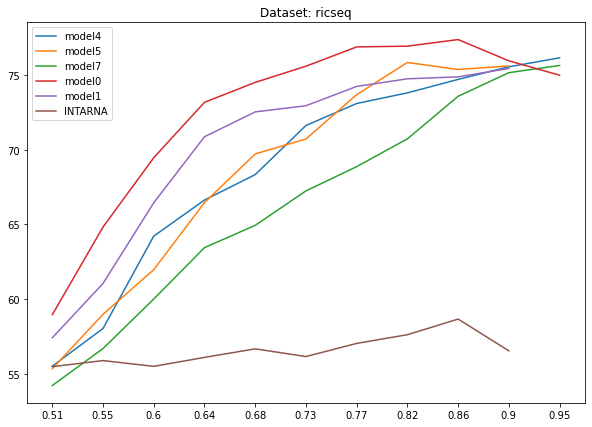

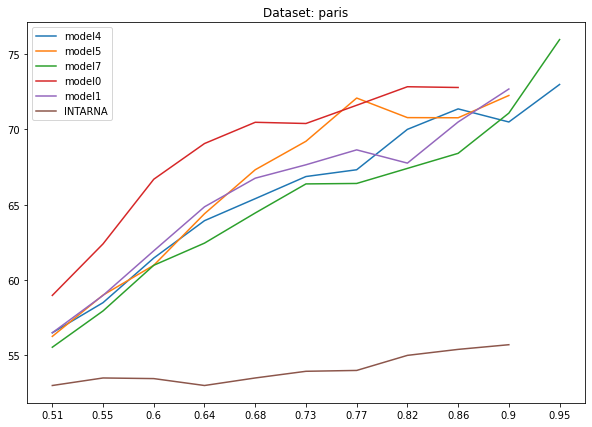

In [62]:
for dataset in model_list:
    row = df_curve.loc[dataset]
    for model in best_models:
        plt.plot(confidence_level, row[model], label = model)
      
    plt.title(f'Dataset: {dataset}')
    plt.legend()
    plt.show()

In [59]:
for i in list(best_models):
    if i != 'INTARNA':
        print(i, name_map[i])

model4 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_parisANDsplashRICSEQval0110
model5 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_parisANDsplashRICSEQval0094
model7 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_parisANDsplashRICSEQval0147
model0 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_parisANDsplashRICSEQval0081
model1 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_parisANDsplashRICSEQval0083


In [36]:
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28_splash103
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_easypretrain10_paristfinetuningSPLASHval29_ricseqSPLASHval60_splashRICSEQval110
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28_splashBEST
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151

In [37]:
columns_to_print = ['model', 
                    'paris_auc_ES', 'paris_auc_EPENHN',
                    'ricseq_auc_ES', 'ricseq_auc_EPENHN',
                    'splash_auc_ES', 'splash_auc_EPENHN']
df_full[df_full['model'].isin(models_selected)|(df_full['model']=='INTARNA')].filter(columns_to_print, axis = 1).round(2)

NameError: name 'models_selected' is not defined

In [ ]:
models_selected = ['model7', 'model9', 'model10', 'model12', 'model15', 'model21', 'model22', 'model23', 'model24', 'model25', 'model26']

In [ ]:
columns_to_print = ['model', 
                    'paris_auc_ES', 'paris_auc_EPENHN',
                    'ricseq_auc_ES', 'ricseq_acc_ES_notrain', 'ricseq_auc_EPENHN',
                    'splash_auc_ES', 'splash_auc_EPENHN']
df_full[df_full['model'].isin(models_selected)|(df_full['model']=='INTARNA')].filter(columns_to_print, axis = 1).round(2)

### Correlation between ricsecTest VS ricseq, splashTest VS splash

Sembra esserci una correlazione abbastanza forte, quindi posso utilizzare i dati di test per fare tutte le altre analisi.

In [ ]:
only_test = False
df_full_F, name_map_F, confidence_level = otain_results(checkpoint_dir_paths, space, n_values, MIN_PERC, only_test)

In [ ]:
ok_ricseq = [ os.path.join(chkpt_folder, i) for i in [
    'all_modelarch2_easypretrain3_paristfinetuningSPLASHval8', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval30',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval20',
             'all_modelarch1_easypretrain7_paristrain22', 
             'all_modelarch1_easypretrain7_paristrain12_trainhq',
             'all_modelarch2_easypretrain3_paristfinetuning13',
             'all_modelarch2_easypretrain3_paristfinetuning14', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval12'
]]



ok_splash = [os.path.join(chkpt_folder, i) for i in [
    'all_modelarch2_easypretrain3_paristfinetuningSPLASHval8', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval30',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval20',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18_ricseqSPLASHvalBEST',
             'all_modelarch1_easypretrain7_paristrain22',
             'all_modelarch1_easypretrain7_paristrain12_trainhq',
             'all_modelarch2_easypretrain3_paristfinetuning13',
             'all_modelarch2_easypretrain3_paristfinetuning14',
             'all_modelarch2_easypretrain3_paristfinetuning14_ricseq20',
             'all_modelarch2_easypretrain3_paristfinetuning14_ricseq23',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18',
             'all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval12',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18_ricseqSPLASHval20',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29_ricseqSPLASHvalBEST'
]]

In [ ]:
map_splash = {}
for i in ok_splash:
    for j in name_map.keys():
        if name_map[j] == i:
            name_map_splash = j
    for j in name_map_F.keys():
        if name_map[j] == i:
            name_map_splash_F = j
    map_splash[name_map_splash] = name_map_splash_F

map_splash = pd.DataFrame.from_dict(map_splash, 'index').reset_index().rename({'index':'name_map', 0:'name_map_F'}, axis = 1)
    
map_ricseq = {}
for i in ok_ricseq:
    for j in name_map.keys():
        if name_map[j] == i:
            name_map_ricseq = j
    for j in name_map_F.keys():
        if name_map[j] == i:
            name_map_ricseq_F = j
    map_ricseq[name_map_ricseq] = name_map_ricseq_F
    
map_ricseq = pd.DataFrame.from_dict(map_ricseq, 'index').reset_index().rename({'index':'name_map', 0:'name_map_F'}, axis = 1)


In [121]:
#assert we dont have to change names of the dataframes, otherwise we have to modify the names, I didnt implement this case
if ((map_ricseq.name_map == map_ricseq.name_map_F).all()) & ((map_splash.name_map == map_splash.name_map_F).all()):
    pass
else:
    raise NotImplementedError

In [122]:
df_ricseq = df_full[df_full['model'].isin(set(map_ricseq['name_map']))][['model', 'ricseq_auc_ES']]
df_ricseq_F = df_full_F[df_full_F['model'].isin(set(map_ricseq['name_map']))][['model', 'ricseq_auc_ES']]

df_splash = df_full[df_full['model'].isin(set(map_splash['name_map']))][['model', 'splash_auc_ES']]
df_splash_F = df_full_F[df_full_F['model'].isin(set(map_splash['name_map']))][['model', 'splash_auc_ES']]

In [123]:
df_ricseq = df_ricseq.merge(df_ricseq_F, on = 'model').drop('model', axis = 1).rename(
    {'ricseq_auc_ES_x':'ricseq_auc_ES_Test', 
    'ricseq_auc_ES_y':'ricseq_auc_ES_Full'}, axis = 1)

df_splash = df_splash.merge(df_splash_F, on = 'model').drop('model', axis = 1).rename(
    {'splash_auc_ES_x':'splash_auc_ES_Test', 
    'splash_auc_ES_y':'splash_auc_ES_Full'}, axis = 1)

Correlation Matrix:
                    ricseq_auc_ES_Test  ricseq_auc_ES_Full
ricseq_auc_ES_Test            1.000000            0.986051
ricseq_auc_ES_Full            0.986051            1.000000


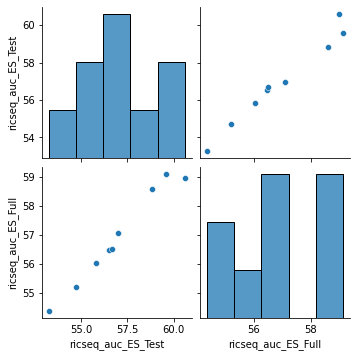

In [124]:
plot_correlation(df_ricseq)

Correlation Matrix:
                    splash_auc_ES_Test  splash_auc_ES_Full
splash_auc_ES_Test            1.000000            0.762477
splash_auc_ES_Full            0.762477            1.000000


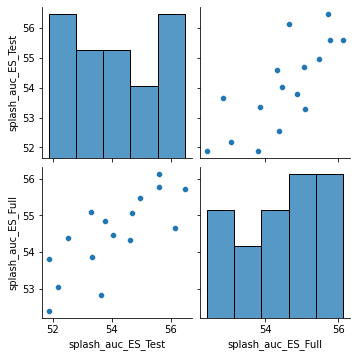

In [125]:
plot_correlation(df_splash)